<h1><center>CS 7642 Spring 2021 Project 1: Replicating Sutton 1988</center></h1>
<h2><center>Evan Jones</center></h2>
<h3><center>February 16, 2021</center></h3>

---

## Importing Standard and User Created Libraries:
We begin by import the modules necessary for the implementation of Sutton's code. Since we are using python we will import NumPy to handle array operations and construction, matplotlib.pyplot as graphing library, and pandas to easily convert arrays into a more manipulatable datatype for further input into matplotlib. In addition to these three-standard python libraries you will also notice I import two other libraries each of which is simply a ".py" file I created to house the separate parts of the implementation. Rand_Walk (RW) contains my implementation of the Random Walk environment as a class identical in function to the specified environment used in Sutton 1988. The main object of the Random_Walk class is the random walk environment object specified as Random_Walk(p=.5). Methods used in this library will also control all the "engine" behind the environment separate from our TD functions. The most used methods within this class are the step() and play_n_episodes() methods. Environmental resets and terminations are handled inside the environment itself see docstrings for further information on the functionality of this class. The libaray TD_Functions (TDF) is another ".py" file that contains my custom implementations of the TD($\lambda$) algorithm for the different use cases required under experiments 1,2, & 3. TD_Lambda_Batch() will be used in replicating experiment 1 and TD_Lambda_Inc() will be used in replicating experiments 2 and 3. Additionally, included in the TDF module is my implementation of TD(0) in a standalone fashion. This implementation was included to verify the results of TD($\lambda$). Finally there are two variants of both TD_Batch() and TD_Inc() titled TD_Batch_Weights() and TD_Inc_Weights() respectively which keep track of the episodic weight vectors for plotting in some supplemental experiments.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Rand_Walk as RW
import TD_Functions as TDF

---

## Specification of Additional Helper Functions:

Next, I define two functions RMSE() and history_to_trajectory() which will both be used throughout the notebook to calculate RMSE between true and predicted state values and the trajectory function to better format the output of our random walk environment for use in incremental learning procedures by converting experience tuples to an array representation. We also declare the variable True_Values which is a vector representing the true state values recognized by Sutton for use in comparing the accuracy our of learning model outputs.


In [2]:
def RMSE(True_Value,Learned_Values):
    diff = Learned_Values - True_Value
    diff_sq = diff**2
    avg = np.sum(diff_sq)/5
    return avg**.5

def history_to_trajectory(history,outcome):
    num_transitions = len(history) -1
    trajectory = np.zeros((num_transitions,3))
    for i in range(0,len(history)-1):
        trajectory[i,0] = history[i].index(1)
        trajectory[i,2] = history[i+1].index(1)
    if outcome[0] == 1:
        trajectory[len(trajectory)-1,1] =1.0
    return trajectory

True_Values = np.array([0.0, (1.0/6.0), (2.0/6.0), (3.0/6.0), (4.0/6.0), (5.0/6.0), 0.0])

---

## Experiment 1: 

Below we implement Sutton's first experiment where we compare the batch TD($\lambda$) performance as measure by RMSE over varying values of lambda. For each value of lambda in the plot below we run the algorithm repeatedly on a training set of 10 episodes until convergence. We repeat this process one hundred times for each value of lambda so runtime may take a while. All 100 training sets are randomly initialized choosing a seed that best compares to Sutton, and the same training sets were used across all values of lambda to keep results directly comparable. Weight vectors are randomly initialized although due to repeated presentations this does not have any impact on the final results. Alpha value was set to be sufficiently small at so as to guarantee convergence at .01. The results below are as follows. 


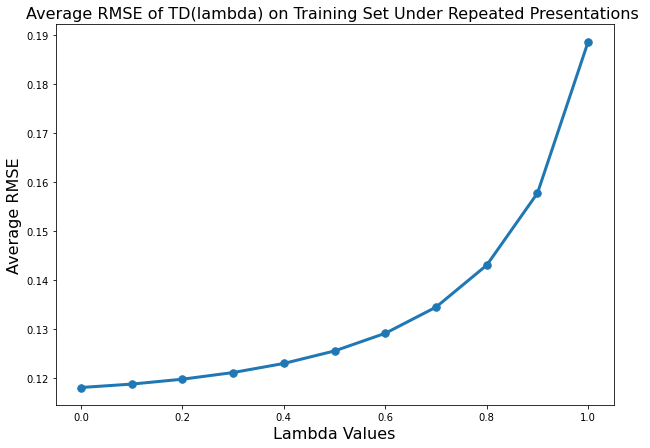

In [16]:
env = RW.Random_Walk_Env(.5)
test_lambda_values = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
output_dict = dict()
se_dict = dict()
for ls in test_lambda_values:
    rms_list = []
    for i in range(1,101):
        np.random.seed(i)
        game_tup = env.play_n_episodes(num_episodes=10)
        Learned_Values = TDF.TD_Lambda_Batch(game_tuples=game_tup,gamma=1.0,lambda_value=ls,alpha=0.01)
        result = RMSE(True_Values,Learned_Values)
        rms_list.append(result)
        
    rms_avg = np.mean(rms_list)
    rms_se = np.std(rms_list)/(len(rms_list)**.5)
    output_dict[ls] = rms_avg
    se_dict[ls] = rms_se
    
lambs = []
rms = []
for a,b in output_dict.items():
    lambs.append(a)
    rms.append(b)
    
plt.figure(figsize=(10,7))    
plt.plot(lambs,rms,marker='.',lw=3,markersize=15)
plt.title('Average RMSE of TD(lambda) on Training Set Under Repeated Presentations ',fontsize=16)
plt.xlabel('Lambda Values',fontsize=16)
plt.ylabel('Average RMSE',fontsize=16)
plt.show()

As further comparison to Sutton we calculate our relevent SE for the data which falls just below his estimate of $\sigma = 0.01$

In [4]:
print('Standard Error = %s'%round(np.mean(list(se_dict.values())),4))

Standard Error = 0.0072


### Compare to Sutton 1988 Figure 3:

<img src='\assets\Sutton_1988_Figure_3.png' height="1000px" width="700px">

### Visualizing Batch TD(0) Convergence

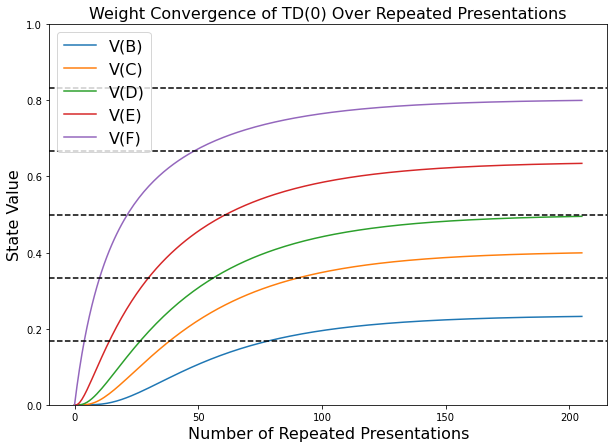

In [15]:
env = RW.Random_Walk_Env(.5)
np.random.seed(1)
game_tup = env.play_n_episodes(num_episodes=10)
vt, vtb = TDF.TD_Lambda_Batch_Weights(game_tuples=game_tup,gamma=1.0,lambda_value=0.0,alpha=.01)
vtb_array = np.array(vtb).T
vtb_array = vtb_array[1:,:]
vtb_array = vtb_array[:-1,:]
df = pd.DataFrame(vtb_array).T
df.columns = ['V(B)','V(C)','V(D)','V(E)','V(F)']
df.plot(figsize=(10,7))
plt.title('Weight Convergence of TD(0) Over Repeated Presentations',fontsize=16)
plt.axhline(y=5/6,color='black',linestyle='--')
plt.axhline(y=4/6,color='black',linestyle='--')
plt.axhline(y=3/6,color='black',linestyle='--')
plt.axhline(y=2/6,color='black',linestyle='--')
plt.axhline(y=1/6,color='black',linestyle='--')
plt.ylabel('State Value',fontsize=16)
plt.legend(fontsize=16)
plt.ylim((0,1))
plt.xlabel('Number of Repeated Presentations',fontsize=16)
plt.show()

See full replication paper for further analysis and discussion of the results.

---

## Experiment 2:

Below I implemented Sutton's second experiment where we compute episodically updated TD($\lambda$) for lambda values of 0.0, 0.3, 0.8, & 1.0. Each lambda value is applied to 100 training sets of 10 episodes each for a variety of alpha values. The average RMSE of each respective hyper-parameter combination is plotted on the y-axis. As per Sutton 1988 weight vectors are initialized for each episode as .5 so as to void right or left side termination bias. The results are plotted below:

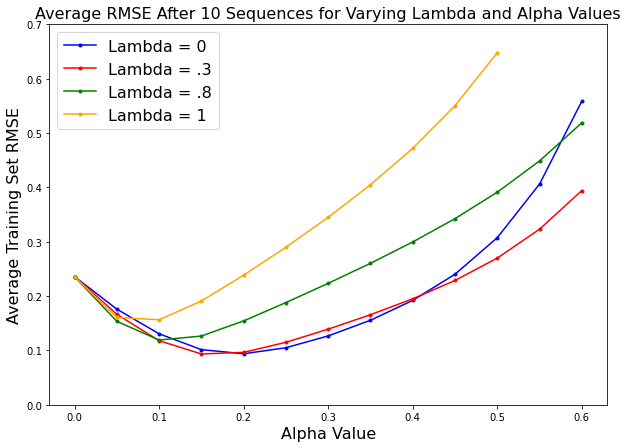

In [11]:
#TD Lambda
env = RW.Random_Walk_Env(.5)
test_lambda_values2 = [0.0,0.3,0.8,1.0]
test_alpha_values = [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,.55,.6,]
output_lister = []
for ls in test_lambda_values2:
    rms_list = []
    for a in test_alpha_values:
        alpha_list = []
        for i in range(0,100):
            np.random.seed(i)
            game_tup = env.play_n_episodes(num_episodes=10)
            Learned_Values = TDF.TD_Lambda_Inc(game_tuples=game_tup,gamma=1.0,lambda_value=ls,alpha=a)
            result = RMSE(True_Values,Learned_Values)
            alpha_list.append(result)
        
        rms_avg = np.mean(alpha_list)
        rms_list.append(rms_avg)
    
    output_lister.append((ls,rms_list))
     
lambda_va = []
re_la = []
for i in output_lister:
    lambda_ = i[0]
    results = i[1]
    lambda_va.append(lambda_)
    re_la.append(results)
lambda_va = np.array(lambda_va)
re_la = np.array(re_la)

df = pd.DataFrame(re_la,lambda_va,columns=test_alpha_values).T
df.columns = ['Lambda Value = 0.0','Lambda Value = .3','Lambda Value = .8','Lambda Value = 1.0']  
wh = list(df['Lambda Value = 1.0'])
    
windrow_als = [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,.4,.45,.5]
plt.figure(figsize=(10,7))
plt.plot(df.index,'Lambda Value = 0.0', data=df,marker='.', color='blue',label='Lambda = 0')
plt.plot(df.index,'Lambda Value = .3',data=df, marker='.', color='red',label='Lambda = .3')
plt.plot(df.index,'Lambda Value = .8',data=df, marker='.', color='green',label='Lambda = .8')
plt.plot(windrow_als,wh[0:11], marker='.', color='orange',label='Lambda = 1')
plt.legend(fontsize=16)
plt.xlabel('Alpha Value',fontsize=16)
plt.ylabel('Average Training Set RMSE',fontsize=16)
plt.ylim((.0,.7))
plt.title('Average RMSE After 10 Sequences for Varying Lambda and Alpha Values',fontsize=16)
plt.show()

### Compare to Sutton 1988 Figure 4:

<img src='assets\Sutton_1988_Figure_4.png' height="1000px" width="700px">


### Visualizing Episodic Weight Updates

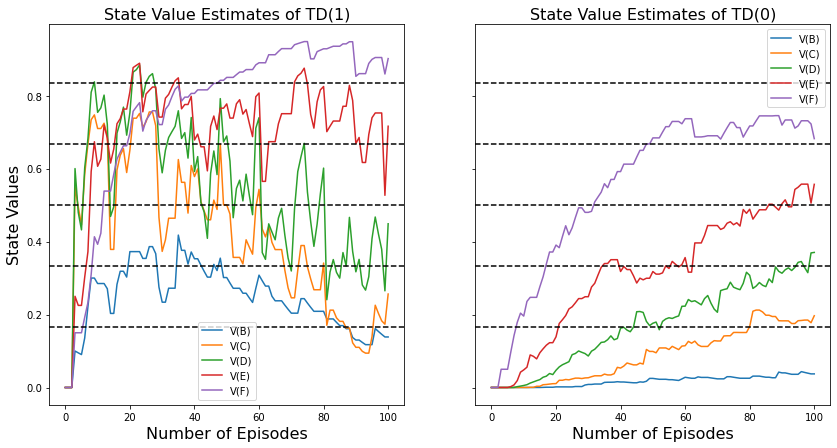

In [22]:
env = RW.Random_Walk_Env(.5)
np.random.seed(1)
game_tup = env.play_n_episodes(num_episodes=100)
vt1, vtb1 = TDF.TD_Lambda_Inc_Weights(game_tuples=game_tup,gamma=1.0,lambda_value=1,alpha=.05)
vt2, vtb2 = TDF.TD_Lambda_Inc_Weights(game_tuples=game_tup,gamma=1.0,lambda_value=0,alpha=.05)
vtb_array1 = np.array(vtb1).T
vtb_array1 = vtb_array1[1:,:]
vtb_array1 = vtb_array1[:-1,:]
vtb_array2 = np.array(vtb2).T
vtb_array2 = vtb_array2[1:,:]
vtb_array2 = vtb_array2[:-1,:]

df1 = pd.DataFrame(vtb_array1).T
df2 = pd.DataFrame(vtb_array2).T


df1.columns = ['V(B)','V(C)','V(D)','V(E)','V(F)']
df2.columns = ['V(B)','V(C)','V(D)','V(E)','V(F)']

fig,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(14,7))
ax1.plot(df1)
ax1.set_title('State Value Estimates of TD(1)', fontsize=16)
ax2.plot(df2)
ax2.set_title('State Value Estimates of TD(0)', fontsize=16)
ax1.axhline(y=5/6,color='black',linestyle='--')
ax1.axhline(y=4/6,color='black',linestyle='--')
ax1.axhline(y=3/6,color='black',linestyle='--')
ax1.axhline(y=2/6,color='black',linestyle='--')
ax1.axhline(y=1/6,color='black',linestyle='--')
ax2.axhline(y=5/6,color='black',linestyle='--')
ax2.axhline(y=4/6,color='black',linestyle='--')
ax2.axhline(y=3/6,color='black',linestyle='--')
ax2.axhline(y=2/6,color='black',linestyle='--')
ax2.axhline(y=1/6,color='black',linestyle='--')
ax2.set_xlabel('Number of Episodes', fontsize=16)
#ax2.set_ylabel('State Values', fontsize=18)
ax1.set_xlabel('Number of Episodes', fontsize=16)
ax1.set_ylabel('State Values', fontsize=16)
ax1.legend(df1.columns)
ax2.legend(df2.columns)
plt.show()

See the full replication paper for further analysis and discussion of the results.


---

## Experiment 3:

Below I implemented Sutton's third and final experiment where we compute episodically updated TD($\lambda$) for lambda values ranging from 0-1 by increments of .1. Each lambda value is applied to 100 training sets of 10 episodes each for optimal alpha values that minimized RMSE for a given lambda value. The average RMSE of each respective hyper-parameter combination is plotted on the y-axis. As per Sutton 1988 weight vectors are initialized for each episode as .5 to void right or left side termination bias. The results are plotted below:

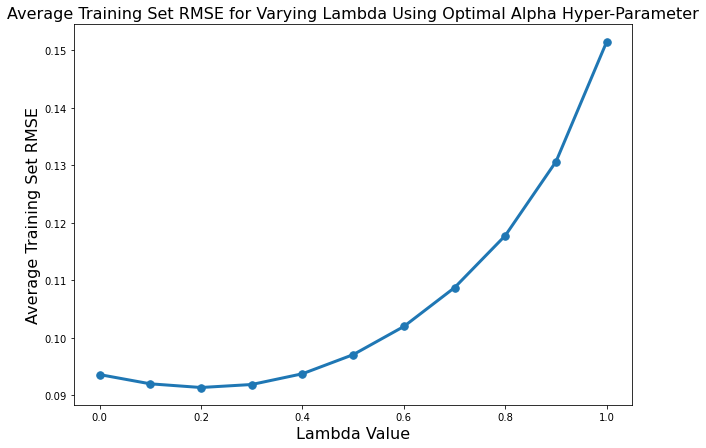

In [18]:
lambdas_range = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
a_vals_range = np.arange(0,.66,step=.01)
best_alpha_values = []
lowest_errors = []

for l in lambdas_range:    
    a_lambda_list = []    
    for als in a_vals_range:
        avg_list = []
        for i in range(0,100):
            np.random.seed(i)
            game_tup = env.play_n_episodes(num_episodes=10)
            Learned_Values = TDF.TD_Lambda_Inc(game_tuples=game_tup,gamma=1.0,lambda_value=l,alpha=als)
            result = RMSE(True_Values,Learned_Values)
            avg_list.append(result)
        a_lambda_list.append(np.mean(avg_list))
    best_alpha_values.append(np.argmin(a_lambda_list))
    lowest_errors.append(np.min(a_lambda_list))
    
plt.figure(figsize=(10,7))
plt.plot(lambdas_range,lowest_errors,marker='.',linewidth=3,markersize=15)
plt.title('Average Training Set RMSE for Varying Lambda Using Optimal Alpha Hyper-Parameter',fontsize=16)
plt.xlabel('Lambda Value',fontsize=16)
plt.ylabel('Average Training Set RMSE',fontsize=16)
plt.show()        

### Compare to Sutton 1988 Figure 5:

<img src='assets\Sutton_1988_Figure_5.png' height="400px" width="600px">

### Supplemental Plot of Optimal Alpha Values Corresponding to Above Plot:

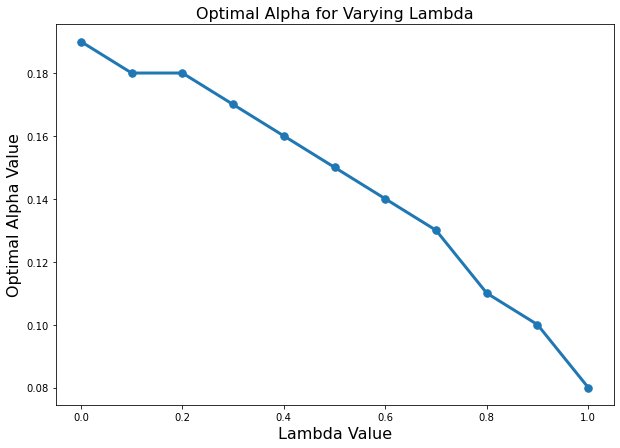

In [19]:
optimal_alpha = []
for i in best_alpha_values:
    optimal_alpha.append(a_vals_range[i])
plt.figure(figsize=(10,7))
plt.plot(lambdas_range,optimal_alpha,marker='.',linewidth=3,markersize=15)
plt.title('Optimal Alpha for Varying Lambda',fontsize=16)
plt.xlabel('Lambda Value',fontsize=16)
plt.ylabel('Optimal Alpha Value',fontsize=16)
plt.show()

See the full replication paper for further analysis and discussion of the results.


---